In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product b.csv', parse_dates=['Month-Year'])


In [3]:
sales_b= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_b = sales_b.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_b.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,494357,2738080,177316
1,2019-02-01,837207,4637013,300290
2,2019-03-01,1278271,7079920,458491
3,2019-04-01,675985,3744057,242463
4,2019-05-01,757687,4196578,271768


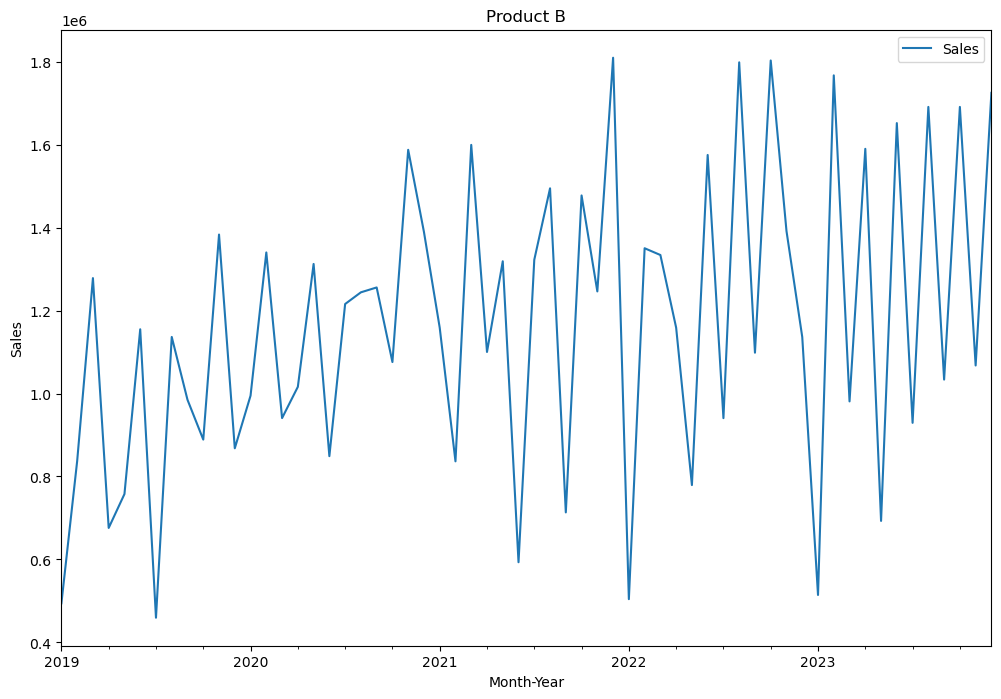

In [5]:
ax = sales_b.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product B')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_b[:48]
test=sales_b[48:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

21:28:29 - cmdstanpy - INFO - Chain [1] start processing
21:28:30 - cmdstanpy - INFO - Chain [1] done processing
21:28:33 - cmdstanpy - INFO - Chain [1] start processing
21:28:34 - cmdstanpy - INFO - Chain [1] done processing
21:28:37 - cmdstanpy - INFO - Chain [1] start processing
21:28:37 - cmdstanpy - INFO - Chain [1] done processing
21:28:40 - cmdstanpy - INFO - Chain [1] start processing
21:28:40 - cmdstanpy - INFO - Chain [1] done processing
21:28:43 - cmdstanpy - INFO - Chain [1] start processing
21:28:44 - cmdstanpy - INFO - Chain [1] done processing
21:28:47 - cmdstanpy - INFO - Chain [1] start processing
21:28:47 - cmdstanpy - INFO - Chain [1] done processing
21:28:50 - cmdstanpy - INFO - Chain [1] start processing
21:28:50 - cmdstanpy - INFO - Chain [1] done processing
21:28:54 - cmdstanpy - INFO - Chain [1] start processing
21:28:54 - cmdstanpy - INFO - Chain [1] done processing
21:28:57 - cmdstanpy - INFO - Chain [1] start processing
21:28:57 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

             rmse  
0   414230.850217  
1   446563.162326  
2   418866.217000  
3   446364.743158  
4   419198.104598  
.. 

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
40,0.2,1.00,additive,320205.404475
54,0.3,3.00,additive,336662.427363
64,0.5,1.00,additive,337349.899047
70,0.5,10.00,additive,366252.117295
58,0.3,10.00,additive,383554.755431
...,...,...,...,...
48,0.3,0.01,additive,490578.386843
38,0.2,0.10,additive,530160.307742
50,0.3,0.10,additive,548586.244300
52,0.3,1.00,additive,553653.019411


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.2, seasonality_prior_scale=1.00,seasonality_mode= 'additive', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

21:59:02 - cmdstanpy - INFO - Chain [1] start processing
21:59:03 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [13]:
future_dates['Market Size'] = sales_b['Market Size']
future_dates['Marketing Expense'] = sales_b['Marketing Expense']

In [14]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,2738080,177316
1,2019-02-01,4637013,300290
2,2019-03-01,7079920,458491
3,2019-04-01,3744057,242463
4,2019-05-01,4196578,271768
5,2019-06-01,6396559,414237
6,2019-07-01,2545212,164826
7,2019-08-01,6294066,407600
8,2019-09-01,5454980,353261
9,2019-10-01,4923556,318846


In [15]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [16]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [17]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
48,2023-01-01,1.549056e+05,7.647853e+04,2.282550e+05
49,2023-02-01,1.212112e+06,1.135176e+06,1.292290e+06
50,2023-03-01,5.082082e+05,4.246090e+05,5.832073e+05
51,2023-04-01,1.000955e+06,9.114672e+05,1.080042e+06
52,2023-05-01,2.487051e+05,1.485417e+05,3.379943e+05
53,2023-06-01,1.037838e+06,9.290785e+05,1.137362e+06
54,2023-07-01,4.190663e+05,2.899964e+05,5.276073e+05
55,2023-08-01,1.043612e+06,9.035451e+05,1.170501e+06
56,2023-09-01,4.917900e+05,3.294928e+05,6.394090e+05
57,2023-10-01,1.011280e+06,8.319732e+05,1.174509e+06


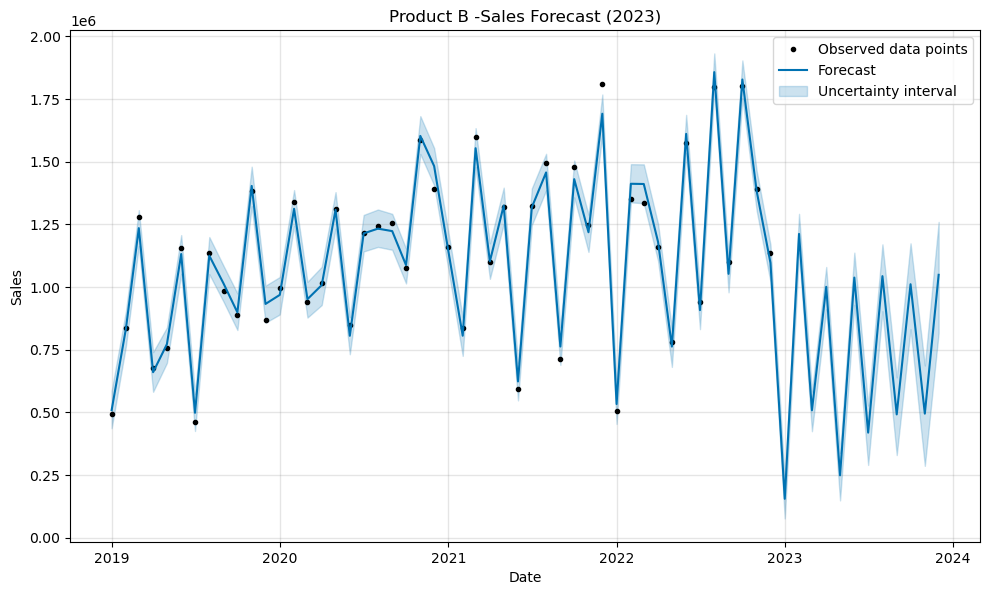

In [18]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product B -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

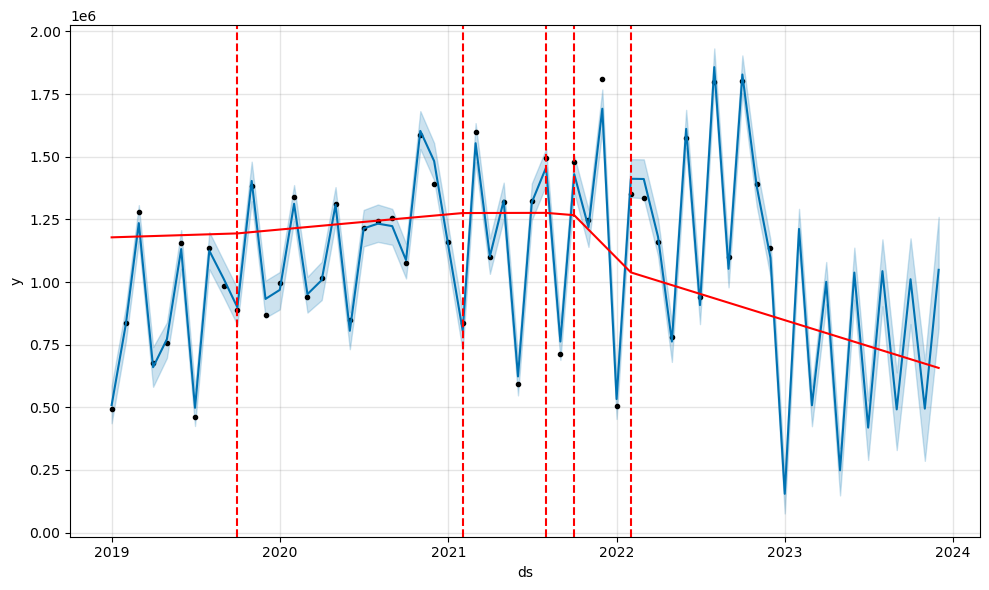

In [19]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

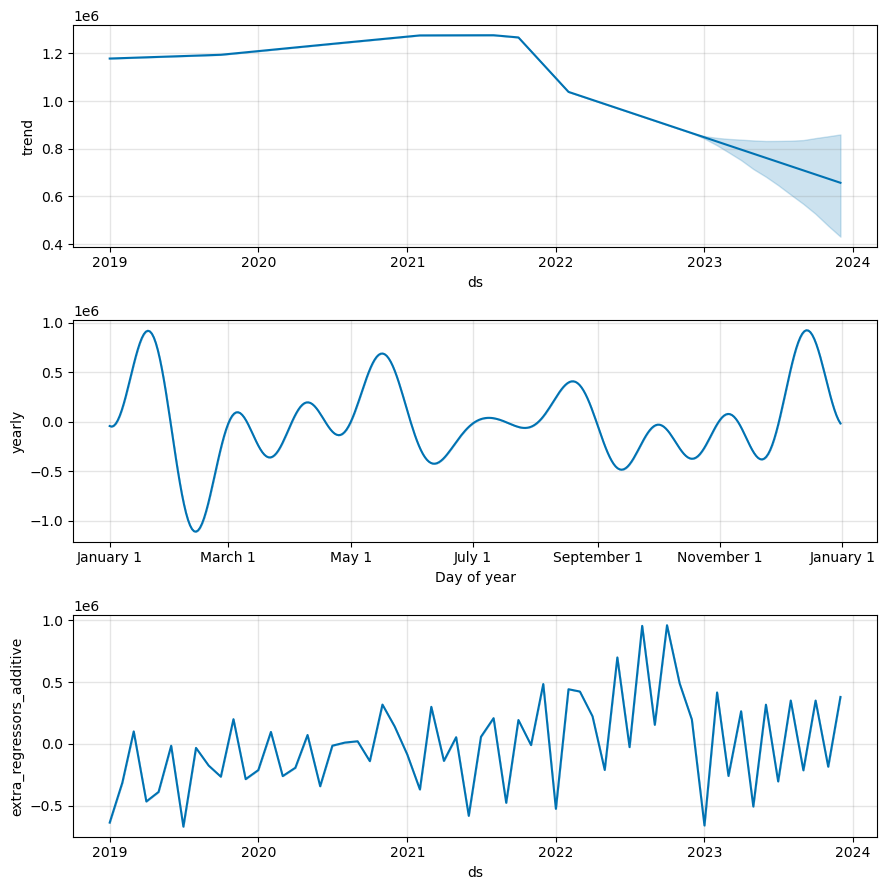

In [20]:
fig2 = model.plot_components(forecast)

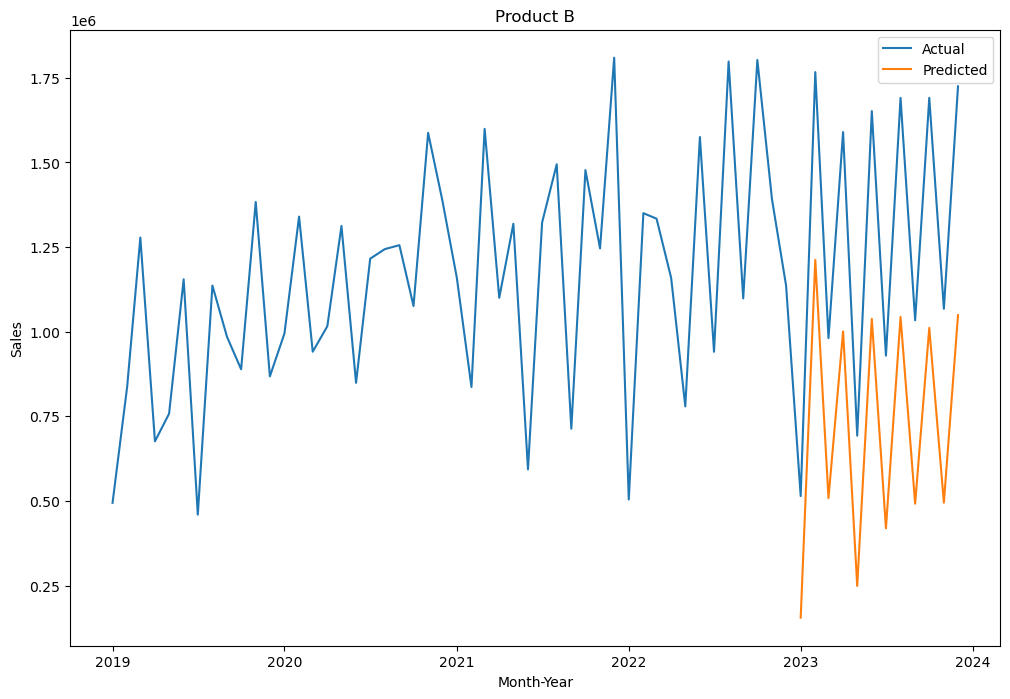

In [21]:
# Reset index of sales_b DataFrame
sales_b_reset_index = sales_b.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_b_reset_index['ds'], sales_b_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product B')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [22]:
#model evaluation

In [23]:
pred=forecasted_df['yhat']
test_df=test['y']

In [24]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 555196.417
MAPE - FB PROPHET: 0.472
MSE - FB PROPHET: 316836370279.592
RMSE - FB PROPHET: 562882.199


In [25]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [26]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,2.629926e+10,162170.474461,162170.474461,0.321586,0.321586,0.277040,0.0
1,62 days,1.499016e+11,387171.274448,387171.274448,0.286743,0.286743,0.250787,0.0
2,90 days,1.127648e+11,335804.709466,335804.709466,0.251739,0.251739,0.223595,0.0
3,121 days,7.731893e+10,278062.822775,278062.822775,0.239971,0.239971,0.214262,0.0
4,151 days,2.114208e+10,145403.169584,145403.169584,0.186577,0.186577,0.170657,1.0
5,182 days,1.419884e+11,376813.459453,376813.459453,0.239231,0.239231,0.213672,1.0
6,212 days,4.158367e+10,203920.754354,203920.754354,0.216788,0.216788,0.195587,1.0
7,243 days,2.052708e+11,453068.220864,453068.220864,0.251923,0.251923,0.223740,1.0
8,274 days,6.360898e+10,252208.215263,252208.215263,0.229606,0.229606,0.205961,1.0
9,304 days,2.211926e+11,470311.146330,470311.146330,0.260866,0.260866,0.230766,1.0


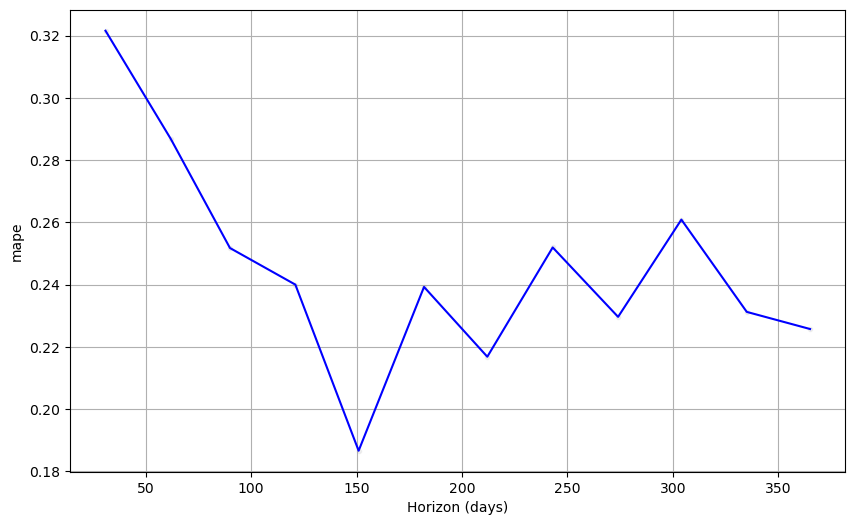

In [27]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [28]:
test_df

48     514369
49    1767039
50     981026
51    1589911
52     692905
53    1651940
54     929333
55    1690948
56    1033615
57    1690948
58    1067615
59    1724948
Name: y, dtype: int64

In [29]:
pred

48    1.549056e+05
49    1.212112e+06
50    5.082082e+05
51    1.000955e+06
52    2.487051e+05
53    1.037838e+06
54    4.190663e+05
55    1.043612e+06
56    4.917900e+05
57    1.011280e+06
58    4.948609e+05
59    1.048906e+06
Name: yhat, dtype: float64

# FORECASTING

In [ ]:
model_forecast = 
model_forecas.add_regressor('Market Size')
model_forecas.add_regressor('Marketing Expense')

In [ ]:
model_forecast.fit(sales_b)

In [ ]:
# Create a DataFrame for future dates 
future_dates_f = model_forecast.make_future_dataframe(periods=12, freq='MS')  # 12 months in 2024

In [ ]:
# Make predictions for the future
forecast_f = model_forecast.predict(future_dates_f)

In [ ]:
forecasted_f_df=forecast_f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [ ]:
forecasted_f_df

In [ ]:
fig = model_forecast.plot(forecast_f, include_legend=True, uncertainty=True)
plt.title('Product B -Sales Forecast (2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model_forecast,forecast_f)

In [ ]:
plot_components_plotly(model_forecast, forecast_f)